In [1]:
import os
data_path = "/workspace/data/Gano-Cat-Breeds-V1_1"
breeds = os.listdir(data_path)
print("Breeds:", breeds)
print("Number of breeds:", len(breeds))


Breeds: ['_Readme_.txt', 'Abyssinian', 'British Shorthair', 'American Bobtail', 'Tuxedo', 'Bengal', 'Persian', 'Bombay', 'Maine Coon', 'Russian Blue', 'Egyptian Mau', 'Sphynx', 'Birman', 'Ragdoll', 'American Shorthair', 'Siamese']
Number of breeds: 16


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_path = "/workspace/data/Gano-Cat-Breeds-V1_1"  # adjust if needed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Make a real dataset that returns (image_tensor, label)
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Safer DataLoader settings for Nano
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Get a batch
images, labels = next(iter(loader))
print(type(images), images.shape)     # e.g. torch.Size([8, 3, 224, 224])
print(type(labels), labels.shape)

<class 'torch.Tensor'> torch.Size([8, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([8])


In [3]:
breeds = [b for b in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, b))]
for breed in breeds[:16]:
    num_images = len(os.listdir(os.path.join(data_path, breed)))
    print(f"{breed}: {num_images} images")

Abyssinian: 375 images
British Shorthair: 375 images
American Bobtail: 375 images
Tuxedo: 375 images
Bengal: 375 images
Persian: 375 images
Bombay: 375 images
Maine Coon: 375 images
Russian Blue: 375 images
Egyptian Mau: 375 images
Sphynx: 375 images
Birman: 375 images
Ragdoll: 375 images
American Shorthair: 375 images
Siamese: 375 images


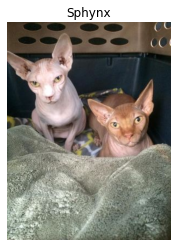

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
sample_breed = random.choice(breeds)
sample_image = random.choice(os.listdir(os.path.join(data_path, sample_breed)))
img_path = os.path.join(data_path, sample_breed, sample_image)
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(sample_breed)
plt.axis("off")
plt.show()

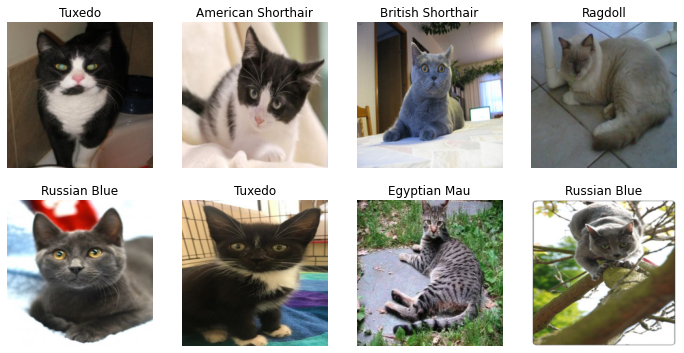

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(min(8, images.size(0))):
    img = images[i]
    if img.size(0) == 1:
        img = img.repeat(3, 1, 1)          
    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0).cpu())
    plt.title(dataset.classes[labels[i]])
    plt.axis("off")
plt.show()

In [6]:
#Splitting into testing and training
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
from torch.utils.data import random_split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 4500
Test set size: 1125


In [7]:
import os, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
num_classes = len(dataset.classes)
num_total = len(dataset)
img_size = 224
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])
test_dataset.dataset.transform = test_tfms
val_size = max(1, int(0.1 * len(train_dataset)))
train_size2 = len(train_dataset) - val_size
train_dataset, val_ds = random_split(train_dataset, [train_size2, val_size])
val_ds.dataset.transform = test_tfms 
len(train_dataset), len(val_ds), len(test_dataset), num_classes

(4050, 450, 1125, 15)

In [9]:
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)

In [10]:
base = models.resnet18(pretrained=True)
for p in base.parameters():
    p.requires_grad = False
in_features = base.fc.in_features
base.fc = nn.Linear(in_features, num_classes)
model = base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [11]:
def run_epoch(loader, train=True):
    model.train(mode=train)
    total, correct, running_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        if train:
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        total += y.size(0)
        correct += (preds == y).sum().item()
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

In [12]:
best_val_acc, best_path = 0.0, "cat_breed_mobilenetv2.pt"
epochs = 8
for ep in range(1, epochs+1):
    t0 = time.time() 
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    if ep == 3:
        for p in base.layer4.parameters():
            p.requires_grad = True
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)  
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
    dt = time.time() - t0
    print(f"Epoch {ep:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f} | "
          f"best {best_val_acc:.3f} | {dt:.1f}s")

Epoch 01 | train loss 1.5236 acc 0.543 | val loss 0.9795 acc 0.716 | best 0.716 | 172.2s
Epoch 02 | train loss 0.9233 acc 0.710 | val loss 0.7767 acc 0.747 | best 0.747 | 159.2s
Epoch 03 | train loss 0.8153 acc 0.733 | val loss 0.6650 acc 0.769 | best 0.769 | 158.2s
Epoch 04 | train loss 0.9319 acc 0.692 | val loss 0.4017 acc 0.856 | best 0.856 | 209.8s
Epoch 05 | train loss 0.4902 acc 0.830 | val loss 0.2236 acc 0.929 | best 0.929 | 207.7s
Epoch 06 | train loss 0.3106 acc 0.891 | val loss 0.1191 acc 0.964 | best 0.964 | 206.8s
Epoch 07 | train loss 0.1786 acc 0.939 | val loss 0.0916 acc 0.964 | best 0.964 | 206.3s
Epoch 08 | train loss 0.1152 acc 0.961 | val loss 0.0324 acc 0.987 | best 0.987 | 204.8s


In [13]:
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        total += y.size(0)
        correct += (preds == y).sum().item()
test_acc = correct / total
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.739


In [15]:
from PIL import Image
def predict_image(path):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = test_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        idx = out.argmax(1).item()
        prob = torch.softmax(out, dim=1)[0, idx].item()
    return full_ds.classes[idx], prob
sample_path = "/workspace/data/Gano-Cat-Breeds-V1_1/British_Shorthair_90.jpg"
pred, p = predict_image(sample_path)
print(f"Predicted: {pred} ({p:.2%})")

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data/Gano-Cat-Breeds-V1_1/British_Shorthair_90.jpg'

In [16]:
import torch
torch.save(model, "cat_breed_model.pth")